In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
#import the data
df = pd.read_csv('RecGym.csv')

In [3]:
#visualizing the dataset
print(df.shape)
print(df.info())
df.describe()

(4703320, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703320 entries, 0 to 4703319
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Subject   int64  
 1   Position  object 
 2   Session   int64  
 3   A_x       float64
 4   A_y       float64
 5   A_z       float64
 6   G_x       float64
 7   G_y       float64
 8   G_z       float64
 9   C_1       float64
 10  Workout   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 394.7+ MB
None


,Subject,Session,A_x,A_y,A_z,G_x,G_y,G_z,C_1
count,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06,4.703320e+06
mean,5.392574e+00,2.802395e+00,5.035507e-01,4.985131e-01,4.977776e-01,4.997782e-01,4.995451e-01,5.002020e-01,4.999879e-01
std,2.845797e+00,1.441097e+00,4.246173e-02,4.969846e-02,3.060175e-02,4.460991e-02,3.632624e-02,4.586471e-02,4.465815e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,4.965000e-01,4.931250e-01,4.945000e-01,4.931250e-01,4.945312e-01,4.929688e-01,4.977754e-01
50%,5.000000e+00,3.000000e+00,5.000000e-01,4.997500e-01,4.998750e-01,4.999625e-01,5.000000e-01,4.999625e-01,5.000488e-01
75%,8.000000e+00,4.000000e+00,5.056250e-01,5.047500e-01,5.032500e-01,5.064437e-01,5.051937e-01,5.054312e-01,5.025115e-01
max,1.000000e+01,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
# finding amount of sessions for each subject for each workout
session_counts = (
    df.groupby(['Workout', 'Subject'])['Session']
      .nunique()
      .unstack(fill_value=0)
)
print(session_counts)

# Find min number of subjects per workout
min_subjects_per_workout = (
    df.groupby('Workout')['Subject']
      .nunique()
      .min()
)

# Find min sessions per (workout, subject)
min_sessions_per_subject = (
    df.groupby(['Workout', 'Subject'])['Session']
      .nunique()
      .min()
)

print("Minimum subjects per workout:", min_subjects_per_workout)
print("Minimum sessions per subject:", min_sessions_per_subject)


Subject       1   2   3   4   5   6   7   8   9   10
Workout                                             
Adductor       5   5   5   5   5   5   5   5   5   5
ArmCurl        5   5   5   4   5   4   5   5   5   5
BenchPress     5   5   5   5   5   5   5   5   5   5
LegCurl        5   5   5   5   5   5   5   5   5   5
LegPress       5   5   5   5   5   5   5   5   5   5
Null           5   5   5   5   5   5   5   5   5   5
Riding         5   5   5   4   5   5   5   5   5   5
RopeSkipping   5   5   5   4   5   5   5   5   5   5
Running        5   5   5   5   5   5   5   5   5   5
Squat          5   5   5   5   5   5   5   5   5   5
StairClimber   5   5   5   5   5   5   5   5   5   5
Walking        5   5   5   5   5   5   5   5   5   5
Minimum subjects per workout: 10
Minimum sessions per subject: 4


In [5]:
## balancing by subject and session
def balance_by_subject_session(df, label_col='Workout', subj_col='Subject', sess_col='Session',
                               n_subjects=None, n_sessions=None, random_state=42):
    rng = np.random.RandomState(random_state)
    balanced_parts = []

    # Compute defaults if not provided
    if n_subjects is None:
        n_subjects = df.groupby(label_col)[subj_col].nunique().min()
    if n_sessions is None:
        n_sessions = df.groupby([label_col, subj_col])[sess_col].nunique().min()

    # Iterate through each workout
    for workout, g_workout in df.groupby(label_col):
        # Randomly select subjects
        subjects = g_workout[subj_col].unique()
        chosen_subjects = rng.choice(subjects, size=n_subjects, replace=False)

        for subj in chosen_subjects:
            g_subj = g_workout[g_workout[subj_col] == subj]
            sessions = g_subj[sess_col].unique()
            chosen_sessions = rng.choice(sessions, size=n_sessions, replace=False)
            
            # Keep all rows belonging to those sessions
            mask = (df[label_col] == workout) & \
                   (df[subj_col] == subj) & \
                   (df[sess_col].isin(chosen_sessions))
            balanced_parts.append(df[mask])

    balanced_df = pd.concat(balanced_parts).reset_index(drop=True)
    return balanced_df


final_df = balance_by_subject_session(df, label_col='Workout', subj_col='Subject', sess_col='Session')

In [6]:
# checking min amount of samples per session
min_samples_per_session = (
    df.groupby(['Workout', 'Subject', 'Session']).size().min()
)

print("Equalizing to:", min_samples_per_session, "samples per session")

# balancing
from sklearn.utils import resample

balanced_sessions = []
for (w, s, sess), g in final_df.groupby(['Workout', 'Subject', 'Session']):
    g_bal = resample(g, n_samples=min_samples_per_session, replace=False, random_state=42)
    balanced_sessions.append(g_bal)

final_df = pd.concat(balanced_sessions).reset_index(drop=True)

Equalizing to: 488 samples per session


In [7]:
## preparing data
X = final_df.drop(columns='Workout')
y = final_df['Workout']

#dividing data into training, cross-validation, and test data
#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (140544, 10) y_train.shape (140544,)
X_cv.shape (46848, 10) y_cv.shape (46848,)
X_test.shape (46848, 10) y_test.shape (46848,)


In [8]:
non_feature_cols = ['Subject', 'Session', 'Position']
X_train = X_train.drop(columns=[col for col in non_feature_cols if col in X_train.columns])
X_cv    = X_cv.drop(columns=[col for col in non_feature_cols if col in X_cv.columns])
X_test  = X_test.drop(columns=[col for col in non_feature_cols if col in X_test.columns])

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled    = scaler.transform(X_cv)
X_test_scaled  = scaler.transform(X_test)

print("X_train_scaled.shape", X_train_scaled.shape, "y_train.shape", y_train.shape)
print("X_cv_scaled.shape", X_cv_scaled.shape, "y_cv.shape", y_cv.shape)
print("X_test_scaled.shape", X_test_scaled.shape, "y_test.shape", y_test.shape)

X_train_scaled.shape (140544, 7) y_train.shape (140544,)
X_cv_scaled.shape (46848, 7) y_cv.shape (46848,)
X_test_scaled.shape (46848, 7) y_test.shape (46848,)


In [10]:
num_features = X_train_scaled.shape[1]
num_classes  = len(y_train.unique())

tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [
        ### START CODE HERE ###
        tf.keras.Input(shape=(num_features,)),
        Dense(256, activation="relu", name="L1"),
        Dense(128, activation="relu", name="L2"),
        Dense(64, activation="relu", name="L3"),
        Dense(num_classes, activation="softmax", name="L4")
        
        ### END CODE HERE ###
    ], name = "model_1"
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# encoding y from string to integer labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_cv_encoded = le.transform(y_cv)
y_test_encoded = le.transform(y_test)

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_data=(X_cv_scaled, y_cv_encoded),
    epochs=100,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
            )
    ],
    
    verbose=1
)

print(f"Stopped at epoch: {len(history.history['loss'])}")

Epoch 1/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.3905 - loss: 1.6636 - val_accuracy: 0.4374 - val_loss: 1.5481
Epoch 2/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4562 - loss: 1.5040 - val_accuracy: 0.4612 - val_loss: 1.4911
Epoch 3/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4738 - loss: 1.4576 - val_accuracy: 0.4727 - val_loss: 1.4648
Epoch 4/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4852 - loss: 1.4292 - val_accuracy: 0.4811 - val_loss: 1.4427
Epoch 5/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4932 - loss: 1.4087 - val_accuracy: 0.4889 - val_loss: 1.4251
Epoch 6/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4987 - loss: 1.3939 - val_accuracy: 0.4925 - val_loss: 1.4151
Epoch 7/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5026 - loss: 1.3816 - val_accuracy: 0.4933 - val_loss: 1.4108
Epoch 8/100
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5066 - lo

In [11]:
# Evaluate
train_loss, train_acc = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
val_loss, val_acc = model.evaluate(X_cv_scaled, y_cv_encoded, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)

print("\n" + "="*50)
print("NEURAL NETWORK RESULTS")
print("="*50)
print(f"Train - Loss: {train_loss:.3f}, Accuracy: {train_acc:.3f}")
print(f"Val   - Loss: {val_loss:.3f}, Accuracy: {val_acc:.3f}")
print(f"Test  - Loss: {test_loss:.3f}, Accuracy: {test_acc:.3f}")


NEURAL NETWORK RESULTS
Train - Loss: 1.305, Accuracy: 0.529
Val   - Loss: 1.384, Accuracy: 0.506
Test  - Loss: 1.392, Accuracy: 0.505


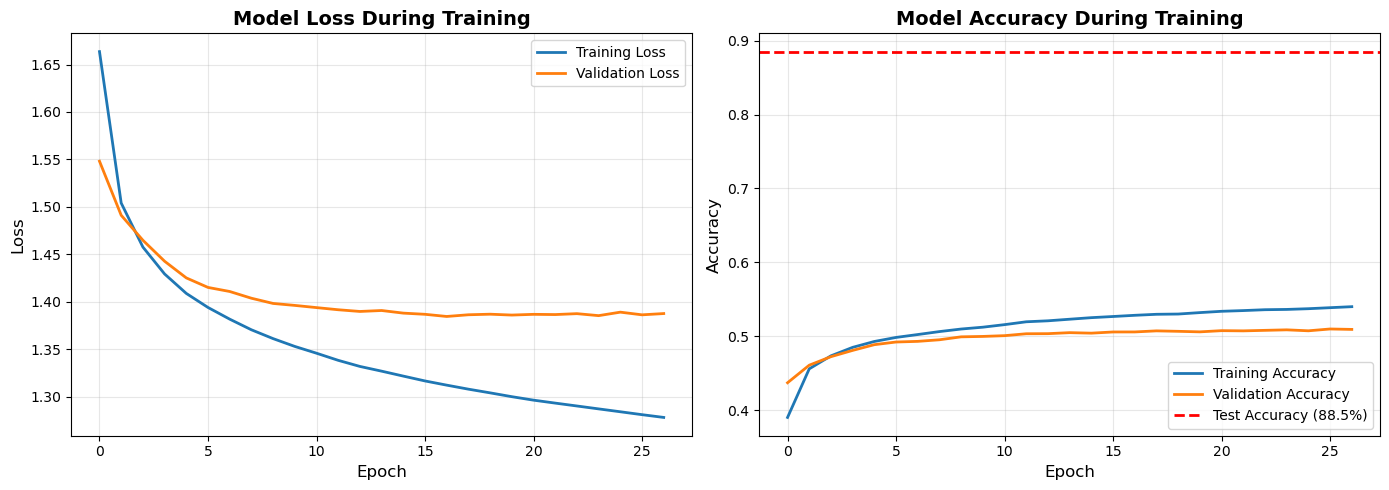

In [12]:
# visualizing the training progress

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.axhline(y=0.885, color='r', linestyle='--', label='Test Accuracy (88.5%)', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

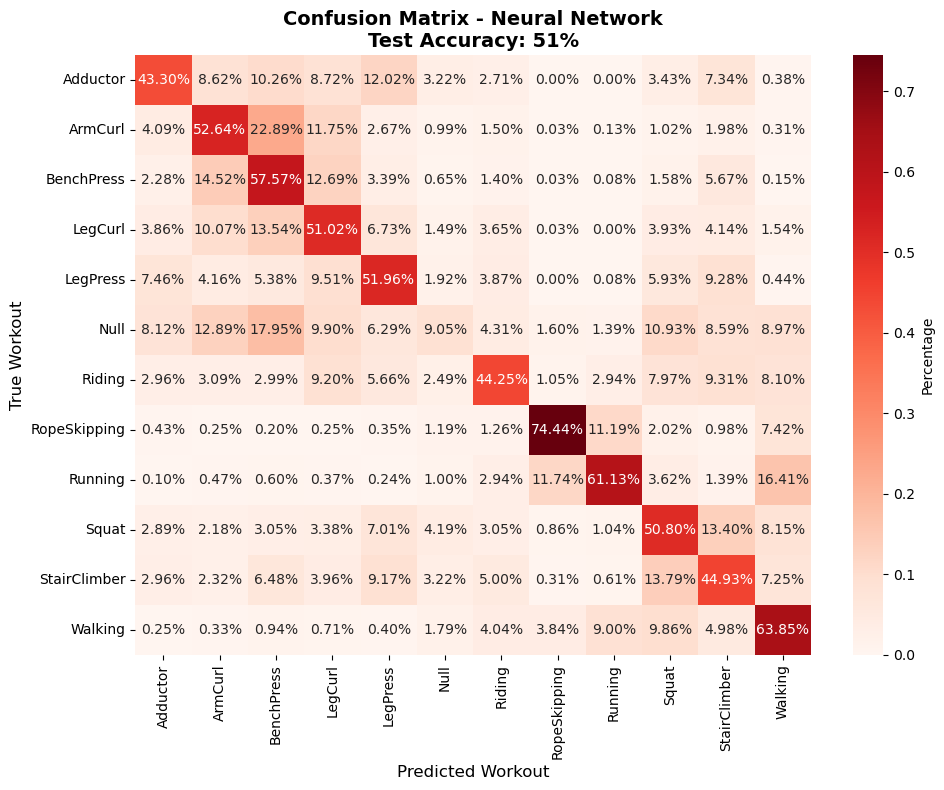


DETAILED CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

    Adductor      0.551     0.433     0.485      3910
     ArmCurl      0.473     0.526     0.498      3932
  BenchPress      0.411     0.576     0.480      3988
     LegCurl      0.419     0.510     0.460      3891
    LegPress      0.487     0.520     0.503      3847
        Null      0.289     0.091     0.138      3878
      Riding      0.562     0.442     0.495      3815
RopeSkipping      0.797     0.744     0.770      3960
     Running      0.691     0.611     0.649      3815
       Squat      0.445     0.508     0.475      3939
StairClimber      0.402     0.449     0.425      3917
     Walking      0.524     0.639     0.576      3956

    accuracy                          0.505     46848
   macro avg      0.504     0.504     0.496     46848
weighted avg      0.504     0.505     0.496     46848


PER-CLASS PERFORMANCE
Adductor            : 43.3% (3910 samples)
ArmCurl             : 52

In [13]:
# performance analysis

from sklearn.metrics import confusion_matrix, classification_report
import math

# Get predictions
train_predictions = model.predict(X_train_scaled, verbose=0)
train_pred_classes = np.argmax(train_predictions, axis=1)

val_predictions = model.predict(X_cv_scaled, verbose=0)
val_pred_classes = np.argmax(val_predictions, axis=1)

test_predictions = model.predict(X_test_scaled, verbose=0)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Confusion Matrix for Test Set
cm = confusion_matrix(y_test_encoded, test_pred_classes)

plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Percentage'})
plt.title(f'Confusion Matrix - Neural Network\nTest Accuracy: {math.ceil(test_acc*100)}%', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Workout', fontsize=12)
plt.xlabel('Predicted Workout', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*60)
print(classification_report(y_test_encoded, test_pred_classes, 
                          target_names=le.classes_,
                          digits=3))

# Per-class accuracy
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE")
print("="*60)
for i, workout in enumerate(le.classes_):
    mask = y_test_encoded == i
    if mask.sum() > 0:
        class_acc = (test_pred_classes[mask] == i).sum() / mask.sum()
        print(f"{workout:20s}: {class_acc:.1%} ({mask.sum()} samples)")

<Figure size 1200x600 with 0 Axes>

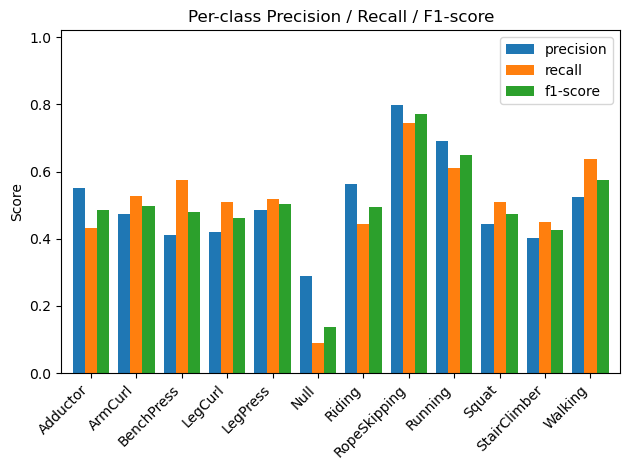

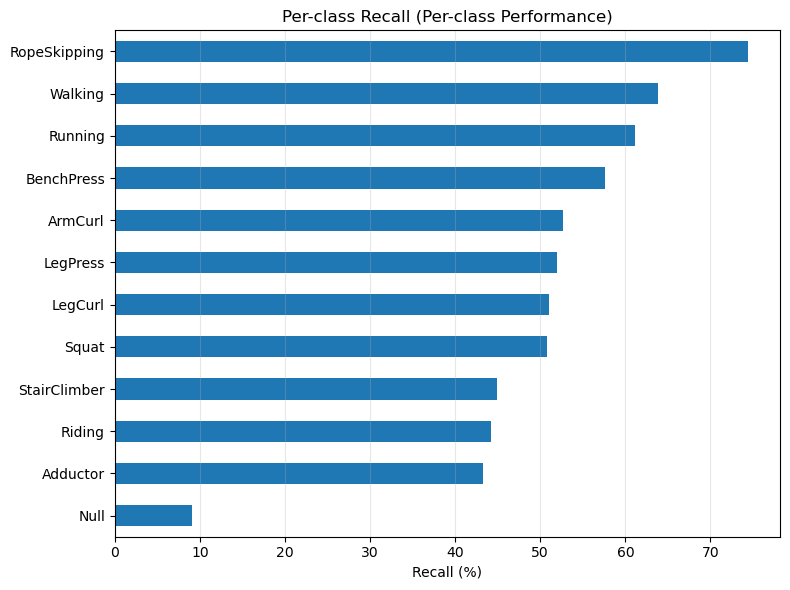

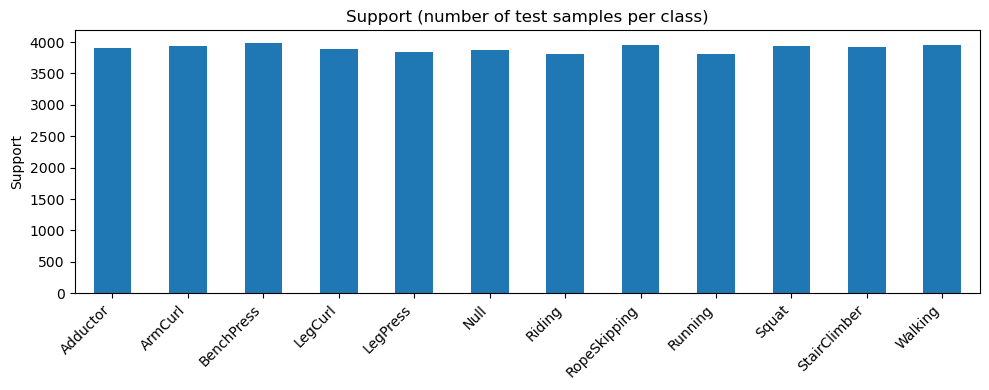

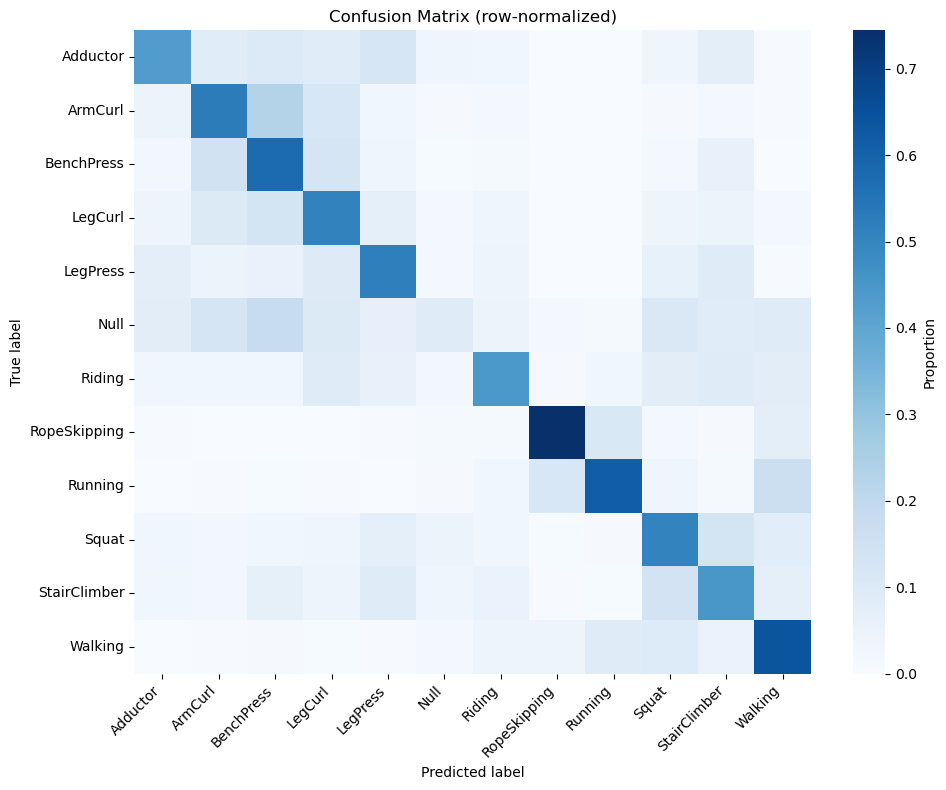

In [14]:

# --- replace these with your variables ---
# y_test: true labels (encoded as ints or strings)
# y_pred: predicted labels (encoded same as y_test)
# label_names: list/array of class names in the same order as encoder.classes_
# Example:
y_test = y_test_encoded
y_pred = test_pred_classes
label_names = le.classes_

# ---------- compute metrics ----------
report_dict = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
# convert to DataFrame for precision/recall/f1/support
metrics_df = pd.DataFrame(report_dict).transpose().iloc[:-3]  # drop accuracy/avg rows

# ensure order matches label_names
metrics_df = metrics_df.reindex(label_names)

# ---------- Plot: grouped bar chart precision/recall/f1 ----------
plt.figure(figsize=(12,6))
metrics_plot = metrics_df[['precision','recall','f1-score']]

metrics_plot.plot(kind='bar', width=0.8)
plt.title('Per-class Precision / Recall / F1-score')
plt.ylabel('Score')
plt.ylim(0,1.02)
plt.xticks(rotation=45, ha='right')
plt.legend(title='')
plt.tight_layout()
plt.savefig('per_class_prf.png', dpi=200)
plt.show()

# ---------- Plot: per-class recall as horizontal bars (Per-class performance) ----------
plt.figure(figsize=(8,6))
rec = metrics_df['recall'] * 100  # as percent
rec.sort_values().plot(kind='barh')
plt.xlabel('Recall (%)')
plt.title('Per-class Recall (Per-class Performance)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_recall.png', dpi=200)
plt.show()

# ---------- Plot: support counts ----------
plt.figure(figsize=(10,4))
support = metrics_df['support'].astype(int)
support.plot(kind='bar')
plt.title('Support (number of test samples per class)')
plt.ylabel('Support')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('per_class_support.png', dpi=200)
plt.show()

# ---------- Confusion matrix (normalized) ----------
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_names)))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # row-normalized

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, xticklabels=label_names, yticklabels=label_names, cmap='Blues',
            annot=False, fmt='.2f', cbar_kws={'label':'Proportion'})
plt.title('Confusion Matrix (row-normalized)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_norm.png', dpi=200)
plt.show()
